# Binary Text Classification of Toxic Comments using Logistic Regression
* Notebook by Adam Lang
* Date: 6/26/2024

# Overview
* In this notebook I am going to perform binary text classification using Logistic Regression of the famous "Toxic Comments" dataset from Kaggle.
* The dataset we will use is from the kaggle toxic comment classification challenge from a few years ago.
* The binary classification task will be to classify the comment as "Toxic" or not.
* Workflow
  * 1. Exploratory Data Analysis
  * 2. Text cleaning
  * 3. Create custom embeddings using Sentence Transformers models from huggingface.
  * 4. Train a binary text classification model using Logisitic Regression.
  * 5. Evaluate the model using standard machine learning metrics for precision, recall, accuracy, and F1 score as well as confusion matrix.

In [ ]:
# install sentence transformers
!pip install -U sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 74.1 MB/s eta 0:00:00


In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# tqdm import
from tqdm import tqdm
tqdm.pandas(leave=False)

# set random seed
np.random.seed(42)

## Sentence Transformers
* This is the model I am experimenting with: https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2
* We will load the model now but not create the embeddings until after we explore and clean the text data.
* The Sentence Transformer models are all listed on the github site. The table of models can be queried for various tasks and compare and contrast models: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [ ]:
## load sentence transformers model
from sentence_transformers import SentenceTransformer

# load model from SBERT
model = SentenceTransformer('paraphrase-mpnet-base-v2')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Upload Data
* We will read the toxic comments dataset from a raw github instance.

In [ ]:
# read train data from github
url = 'https://raw.githubusercontent.com/nicknochnack/CommentToxicity/main/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv'

df = pd.read_csv(url)

In [ ]:
# head of df
df.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

## Pre-processing and Exploratory Data Analysis (EDA)
* We can import stop_words from spacy.
* NLTK is another option as well.

In [ ]:
import spacy
import string

# spacy model
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words
print(stop_words)

{'just', 'anyway', "'ll", 'our', 'fifty', 'himself', 'until', 'herein', 'meanwhile', 'of', '’m', 'cannot', 'itself', '’d', 'yours', 'else', 'now', 'next', '‘d', 'though', 'although', 'hereafter', 'their', 'less', 'former', 'enough', 'on', 'by', "'m", 'above', 'done', 'across', 'into', 'that', 'much', 'show', 'beside', 'many', 'still', 'noone', 'perhaps', 'nevertheless', 'used', "'s", 'through', 'together', 'none', 'ca', 'behind', 'everywhere', 'it', 'ten', 'whence', 'another', 'unless', 'because', 'those', 'whither', 'whole', 'empty', '‘re', 'forty', 'whereafter', 'along', 'who', 'mostly', 'please', 'up', 'see', 'around', 'nobody', 'or', 'top', 'hers', 'anything', 'n‘t', 'latter', 'with', 'been', 'if', 'sometimes', 'seem', 'hence', 'would', 'will', 'yourselves', 'her', 'either', 'off', 'whose', "'ve", 'never', 'against', 'to', 'neither', 'thus', 'whereas', 'why', 'throughout', 'wherever', '’ll', 'amongst', 'a', 'does', 'various', 'any', 'had', 'amount', 'least', 'should', 'was', 'thru'

### Punctuations
* We can import punctuations

In [ ]:
# punctuations
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


### Pre-processing Data function
* We can do different things with this function, but generally for classification tasks it is a good idea to pre-process the text. Below we will do following:
1. lemmatize (root) each word
2. lowercase (normalize) each word
3. remove punctuations
* Note about stop words. I am not going to remove the stop words. This really depends on the dataset your are using and your modeling approach. Since I am going to be using the Sentence Transformers these models actually need the stop words for full semantic context. Also, by default the sentence transformers ignore the stop words using the attention mechanism. You can actually change this default setting in the sentence transformers class if you desire but I am not going to do that.



### EDA - Continued
* Some things to consider
1. Word frequencies - as I mentioned above, I am curious as to the most frequent words in our corpus. Are they stop words? If so do we need to remove them?
2. Text cleaning - as I mentioned above, the text is not entirely clean with noted:

Upper case and lower case -- the text is not "normalized" which isn't helpful for any NLP machine learning project unless we were using a transformer such as Bert-base-uncased which does not distinguish between uppercase and lowercase words.
  * punctuation
  * stop words
  * special characters
  * white space
  * acronyms and abbreviations and 'slang' terms
  * emoticons (maybe emojis too?)

3. While the SBERT transformers to encode the text and apply a tokenizer 'under the hood', it would be prudent to pre-process the text and remove some of the standard linguistic issues such as punctuation, white space and special characters before creating the embeddings.

4. The acronyms, abbreviations and 'slang' terms as well as 'emoticons' and 'emojis' could be further evaluated, as there are BERT based transformer models and even datasets or corpora to analyze, pre-process and perform classification with. Some example resources:
 * Emojis: https://towardsdatascience.com/emojis-aid-social-media-sentiment-analysis-stop-cleaning-them-out-bb32a1e5fc8e
 * Emojis: https://medium.com/@pokharelbikash981/nlp-era-analyzing-texts-with-emojis-fd1a75f81f0f
 * University of Toronto corpora of slang and urban dictionary terms used in social messages: https://www.cs.toronto.edu/~yangxu/data.html
 * Urban Dictionary Dataset: https://metatext.io/datasets/urban-dictionary-dataset
 * SOCBert: pre-trained transformer on twitter and reddit posts
     * paper: https://aclanthology.org/2023.insights-1.5.pdf
     * huggingface: https://huggingface.co/sarkerlab/SocBERT-base
* Emoticon and Emoji Python library and corpus: https://github.com/NeelShah18/emot/tree/master
* Slang terms pre-processing: https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing#Slangs
* Other pre-processing advanced things: https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing#Conversion-of-Emoticon-to-Words

## EDA - Exploratory Data Analysis
* Before we pre-process and clean the text, lets look at some samples of the text column first.

In [ ]:
## print samples of the text column
df[['comment_text']].sample(10)

comment_text
119105  Geez, are you forgetful!  We've already discus...
131631  Carioca RFA \n\nThanks for your support on my ...
125326  "\n\n Birthday \n\nNo worries, It's what I do ...
111256  Pseudoscience category? \n\nI'm assuming that ...
83590   (and if such phrase exists, it would be provid...
37546   , 9 October 2007 (UTC)\n\nP.s, the delta funct...
98371                ]]- 10 September 1910, [[[Couvet]] )
67118             Negro league baseball task-force talk].
129625  List of My Three Sons episodes \n\nI saw you r...
48941   Quoting Loremaster: In order to make sure you ...

In [ ]:
## lets index a specific text comment
df['comment_text'].iloc[150370]

'Please\nhttp://ru.wikipedia.org/wiki/%D0%A3%D1%87%D0%B0%D1%81%D1%82%D0%BD%D0%B8%D0%BA:Alex_Smotrov\nThanks78.85.139.170'

Summary:
* We can see the text has a lot of various issues related to punctuation as well as website addresses.
* It would be a good idea to remove these issues prior to building a machine learning model.

## Text Cleaning
* First we will create a function to handle these issues, then apply it.

In [ ]:
# First apply a clean text function
import re

# func to clean basic text
def clean_text(text):

  # lower case the text - normalize case
  text = text.lower()

  # remove comma, period, newline chars
  text = re.sub(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\n]', ' ', text)

  # remove internet addresses
  text = re.sub(r'https?://(www\.)?([a-zA-Z-]+)\.[a-zA-Z]+', '', text)


  # replace hyphen with blank space
  text = re.sub(r'-', ' ', text)

  # replace double blank spaces
  text = re.sub('  ', ' ', text)

  return text

In [ ]:
## apply this function to the 'comment_text' column
df['cleaned_text'] = df['comment_text'].apply(clean_text)

In [ ]:
## print the new df column with cleaned_text
df['cleaned_text'].head()

0    explanation why the edits made under my userna...
1    d'aww he matches this background colour i'm se...
2    hey man i'm really not trying to edit war it's...
3     more i can't make any real suggestions on imp...
4    you sir are my hero any chance you remember wh...
Name: cleaned_text, dtype: object

## Most Frequent word count
* Let's find a count of the most frequent words, just to see if there are stop words that dominate the data.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the data
X = vectorizer.fit_transform(df['cleaned_text'])

# Sum up the counts of each vocabulary word
word_counts = X.sum(axis=0)

# Map from integer feature name to original token string
words = vectorizer.get_feature_names_out()

# Create a dictionary of words and their counts
word_freq = {words[i]: word_counts[0, i] for i in range(len(words))}

print(word_freq)

{'00': 792, '000': 1875, '0000': 9, '00000': 2, '000000': 150, '0000000': 1, '00000000': 1, '0000000027': 1, '00000001': 1, '00000003': 1, '00000050': 1, '000001': 1, '00000112000': 1, '000002': 2, '000002000004000008000016': 1, '0000030422': 1, '0000035': 1, '000023405011': 1, '00004': 1, '000045': 1, '00007632': 1, '000080': 1, '00008b': 1, '00009c': 1, '0000z': 14, '0001': 19, '000111002': 1, '00012': 1, '000131088': 1, '0002': 2, '000260': 1, '0002tree': 1, '0003': 4, '000319821': 1, '00033': 3, '00035': 1, '000352': 1, '00037': 1, '00038': 1, '0003º': 1, '0004': 1, '000500': 1, '00052': 1, '00053': 1, '0006': 1, '00075': 1, '00098': 1, '000b01c5b9f8': 1, '000feet': 1, '000ft': 4, '000http': 1, '000hz': 2, '000k': 1, '000kg': 5, '000km': 1, '000lb': 1, '000poland2': 1, '000s': 2, '000shp': 1, '000soviet': 1, '000th': 5, '000unknownunknown': 2, '000unknownunknownhungary': 1, '000unknownunknownitaly': 1, '000unknownunknownromania3': 1, '000unknownunknowntotal': 2, '000v': 2, '000x': 

In [ ]:
# create a sorted dictionary to sort the results
keys = list(word_freq.keys())
values = list(word_freq.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

print(sorted_dict)

{'𐌴𐌹': 1, 'skyearth': 1, 'skyfish': 1, 'skyglow': 1, 'horiz': 1, 'horisontaly': 1, 'horik': 1, 'horii': 1, 'horenstein': 1, 'horendous': 1, 'horemheb': 1, 'skydrive': 1, 'skyhawks': 1, 'horcruxes': 1, 'skylar': 1, 'horbury': 1, 'horay': 1, 'skylark2007': 1, 'skylark2008': 1, 'skylights': 1, 'horan': 1, 'horacio': 1, 'skynet': 1, 'skyjump': 1, 'horko': 1, 'horlivka': 1, 'horlo': 1, 'hornstein': 1, 'hornsby': 1, 'skxwu7mesh': 1, 'skxwxu7mesh': 1, 'horning': 1, 'horninc': 1, 'hornfels': 1, 'horney': 1, 'sky83': 1, 'hornetman': 1, 'hornetfan': 1, 'skyboiz': 1, 'horned': 1, 'hornblowers': 1, 'skycop12': 1, 'hornbeck': 1, 'hormuzan': 1, 'hormozgan': 1, 'hormononal': 1, 'skydiving': 1, 'skydome': 1, 'hormesis': 1, 'horman': 1, 'hoppus': 1, 'hornswaggle': 1, 'hopps': 1, 'hoppin': 1, 'skyy': 1, 'hopefulls': 1, 'hopefull': 1, 'skân': 1, 'skäpperöd': 1, 'skärpt': 1, 'hopatcong': 1, 'hopalong': 1, 'skåne': 1, 'skåneländska': 1, 'skywriter': 1, 'hoovered': 1, 'skënderbeut': 1, 'hooton': 1, 'hooters

In [ ]:
# create a sorted dataframe
df_freq = pd.DataFrame(list(sorted_dict.items()), columns=['word','frequency']).reset_index(drop=True)
df_freq.head(20)

word  frequency
0            𐌴𐌹          1
1      skyearth          1
2       skyfish          1
3       skyglow          1
4         horiz          1
5   horisontaly          1
6         horik          1
7         horii          1
8    horenstein          1
9     horendous          1
10     horemheb          1
11     skydrive          1
12     skyhawks          1
13    horcruxes          1
14       skylar          1
15      horbury          1
16        horay          1
17  skylark2007          1
18  skylark2008          1
19    skylights          1

In [ ]:
df_freq.tail(20)

word  frequency
185942    if      58646
185943  with      59630
185944  your      63408
185945   are      72056
185946  have      72246
185947    as      77462
185948    be      83493
185949    on      90016
185950   not      93825
185951  this      97673
185952   for     102987
185953    in     145698
185954    it     148654
185955  that     160876
185956    is     176497
185957   you     218326
185958   and     224281
185959    of     225067
185960    to     297510
185961   the     497185

In [ ]:
df_freq.sort_values(by='frequency',ascending=False).head(20)

word  frequency
185961   the     497185
185960    to     297510
185959    of     225067
185958   and     224281
185957   you     218326
185956    is     176497
185955  that     160876
185954    it     148654
185953    in     145698
185952   for     102987
185951  this      97673
185950   not      93825
185949    on      90016
185948    be      83493
185947    as      77462
185946  have      72246
185945   are      72056
185944  your      63408
185943  with      59630
185942    if      58646

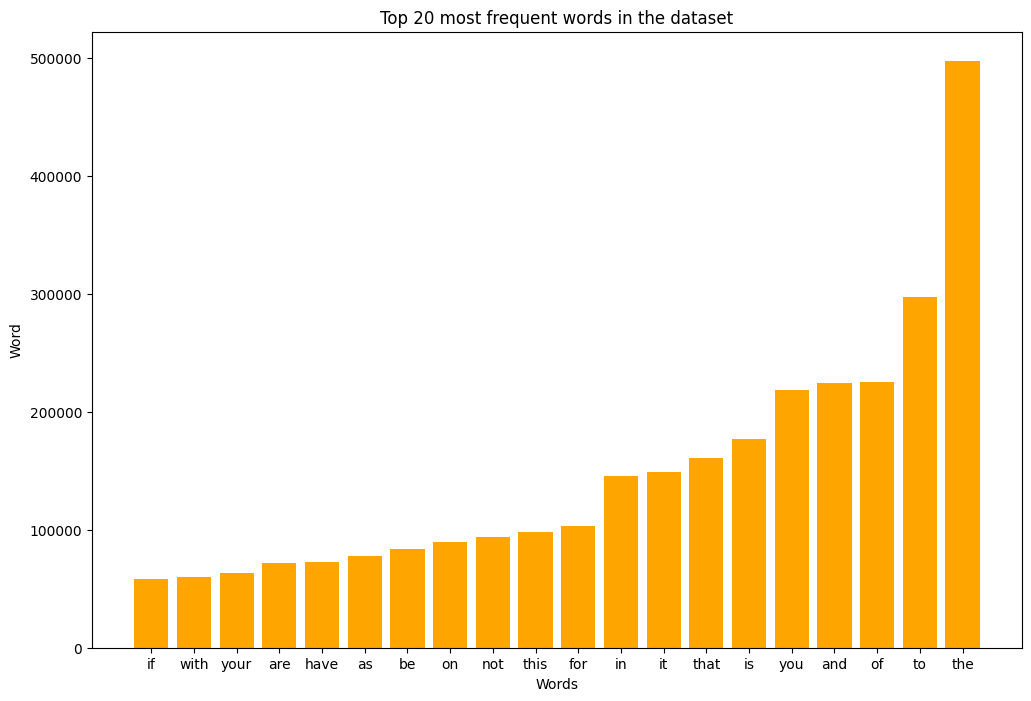

In [ ]:
## Lets visualize this
plt.figure(figsize=(12,8))
plt.bar(list(sorted_dict.keys())[-20:], list(sorted_dict.values())[-20:],color='orange')
plt.xlabel('Words')
plt.ylabel('Word')
plt.title('Top 20 most frequent words in the dataset')
plt.show();

Summary:
* So its pretty obvious that stop words make up the most frequent terms in the data.
* As I mentioned above, I am not going to remove these because sentence transformers are able to handle and ignore stop words to use them in context with the attention mechanism.

## Remove stop words and lemmatize
* This is an optional step

In [ ]:
### Remove stop words and lemmatize text
#def spacy_tokenizer(sentence):
  # creates token object, used to create docs with linguistic annotations
 # doc = nlp(sentence)

  # lemmatizing (root of word) each token and convert each token to lowercase
  #my_tokens = [word.lemma_.lower().strip() for word in doc]

  # stop word and punctuation removal
  #my_tokens = [word for word in my_tokens if word not in stop_words and word not in punctuations]

  # join tokens after tokenizing
  #sentence = " ".join(my_tokens)
  ## now return the pre-processed text data
  #return sentence



In [ ]:
## new df
df.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  \
0             0        0       0       0              0   
1             0        0       0       0              0   
2             0        0       0       0              0   
3             0        0       0       0              0   
4             0        0       0       0              0   

                                        cleaned_text  
0  explanation why the edits made under my userna...  
1  d'aww he matches this background colour i'm se...  
2  hey man i'm really not trying to edit war it's...  
3   more i can't make any real suggestions on imp...  
4  you sir are my hero any chance you remember wh...

## EDA on the target variable
* Let's take a look at the target variable and check for target class imbalance.

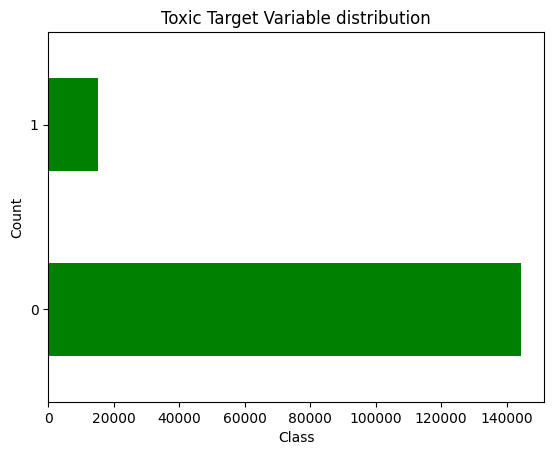

In [ ]:
## plot the target variable
df['toxic'].value_counts().plot(kind='barh', color='green')
plt.title('Toxic Target Variable distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show();

Summary
* It's pretty obvious the target variable is significantly imbalanced, we will have to perform data augmentation so that our model does not become biased on one target class over the other.

## Data Augmentation
* The target class 'Toxic' comments - 1 is severely imbalanced here so we should consider a resampling technique.
* I will use sampling with replacement, but there are other methods such as SMOTE (Synthetic Minority Over-sampling Technique) which generates synthetic examples of the minority class using the k-nearest neighbors of these cases. However, creating synthetic samples may not be ideal here.

In [ ]:
## resmaple module from sklearn
from sklearn.utils import resample

In [ ]:
# get the counts of each target value
df_maj = df[df.toxic==0]
df_min = df[df.toxic==1]

In [ ]:
## shapes of these sub dataframes
print(f"Shape of majority class: {df_maj.shape}")
print(f"Shape of minority class: {df_min.shape}")

Shape of majority class: (144277, 9)
Shape of minority class: (15294, 9)


In [ ]:
## upsampling the minority class
df_min_upsamp = resample(df_min, # imbalanced class we need to upsample
                         replace=True, # sample with replacement
                         n_samples=len(df_maj), # match len of majority df
                         random_state=42) #reproducible

In [ ]:
## concatenate the 2 dataframes
df_upsamp = pd.concat([df_maj, df_min_upsamp])

In [ ]:
# check value counts
df_upsamp['toxic'].value_counts()

toxic
0    144277
1    144277
Name: count, dtype: int64

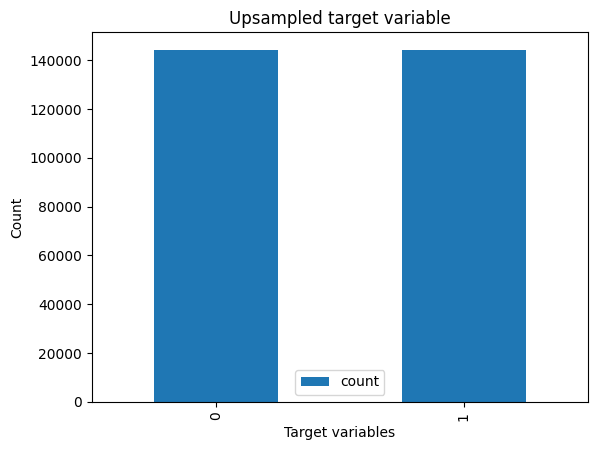

In [ ]:
## plot this result
df_upsamp['toxic'].value_counts().plot(kind='bar')
plt.title('Upsampled target variable')
plt.xlabel('Target variables')
plt.ylabel('Count')
plt.legend()
plt.show();

Summary:
* Great the target class is balanced now, so let's move on.

## Feature Engineering
* Before creating a train test split of our features I am going to create a new dataframe with the targets and the cleaned text.

In [ ]:
## create new dataframe
final_df = df_upsamp[['toxic','cleaned_text']]
final_df.head()

toxic                                       cleaned_text
0      0  explanation why the edits made under my userna...
1      0  d'aww he matches this background colour i'm se...
2      0  hey man i'm really not trying to edit war it's...
3      0   more i can't make any real suggestions on imp...
4      0  you sir are my hero any chance you remember wh...

In [ ]:
## lets check the value counts of the target variable
final_df['toxic'].value_counts()

toxic
0    144277
1    144277
Name: count, dtype: int64

## Now create the train test split

In [ ]:
## first we need to create the X and y variables
X = final_df.drop('toxic', axis=1)
y = final_df['toxic']

In [ ]:
# lets look at X now
X[:10]

cleaned_text
0   explanation why the edits made under my userna...
1   d'aww he matches this background colour i'm se...
2   hey man i'm really not trying to edit war it's...
3    more i can't make any real suggestions on imp...
4   you sir are my hero any chance you remember wh...
5     congratulations from me as well use the tool...
7   your vandalism to the matt shirvington article...
8   sorry if the word 'nonsense' was offensive to ...
9   alignment on this subject and which are contra...
10   fair use rationale for image wonju jpg thanks...

In [ ]:
# lets look at y
y[:10]

0     0
1     0
2     0
3     0
4     0
5     0
7     0
8     0
9     0
10    0
Name: toxic, dtype: int64

Now create the split

In [ ]:
from sklearn.model_selection import train_test_split

## train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

In [ ]:
# lets see the shapes
# shape of train and test
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_text: {y_test.shape}")

Shape of X_train: (230843, 1)
Shape of X_test: (57711, 1)
Shape of y_train: (230843,)
Shape of y_text: (57711,)


## Create Embeddings
* We will now create the embeddings using sentence transformers.
* Instead of using the Sentence Transformers library I am going to use the model itself as well as the tokenizer from huggingface. There are various reasons to use this approach instead of Sentence Transformers alone. I personally think this approach is better for a few reasons:
1. Allows you to create the embeddings in batches which prevents excessive memory storage and overload on your system.
2. Allows use of the pre-trained sentence transformer model with its tokenizer.
3. Also can allow for customization.
* We will also use mean-pooling to create these embeddings. What are mean-pooled embeddings?
* Mean-pooled embeddings is a technique to aggregate embeddings (vector representations) of individual tokens in a sequence (e.g., words in a sentence) into a **single fixed-size vector that represents the entire sequence.** This is done by taking the mean of the embeddings across a specific dimension, usually the sequence length dimension.
* Full details:
  * Sequence Embeddings: Consider a sequence (e.g., a sentence) that has been converted into embeddings. Each token (e.g., word) in the sequence is represented by an embedding vector of a fixed size. If the sequence has (N) tokens and each embedding is of size (D), the embeddings for the sequence can be represented as a matrix of size (N \times D).
  * **Mean Pooling:** To obtain a mean-pooled embedding for the entire sequence, you calculate the mean of these embeddings across the sequence length ((N)). This operation reduces the (N \times D) matrix to a single vector of size (D), where each element of the resulting vector is the mean of the corresponding elements across all (N) embeddings.
 * Result: The resulting mean-pooled vector is a compact representation of the entire sequence, capturing the average of the information contained in the embeddings of all tokens in the sequence.

Mean-pooled embeddings are useful in tasks where you need a fixed-size representation of variable-length sequences, such as document classification, sentiment analysis, or any other task where the input is textual data of varying lengths. This technique is simple yet effective for aggregating information across a sequence, **although it may not always capture the best representation for all types of data or tasks, especially when the order of tokens is crucial.**

In [ ]:
# import libraries
from transformers import AutoModel, AutoTokenizer # huggingface imports -- need token for this
from tqdm import tqdm
from typing import List
import torch

In [ ]:
# Load tokenizer and model from HuggingFace
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Setup device agnostic code in pytorch --> send it to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
## function to create embeddings
def create_embeddings(texts: List[str], batch_size: int):
    all_embeddings = []
    print(f"Total number of records: {len(texts)}")
    print(f"Num batches: {(len(texts) // batch_size) + 1}")

    # Extract embeddings for the texts in batches
    for start_index in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[start_index:start_index + batch_size]

        # Generate tokens and move input tensors to GPU
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Extract the embeddings. no_grad because the gradient does not need to be computed
        # since this is not a learning task
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the last hidden stated and pool them into a mean vector calculated across the sequence length dimension
        # This will reduce the output vector from [batch_size, sequence_length, hidden_layer_size]
        # to [batch_size, hidden_layer_size] thereby generating the embeddings for all the sequences in the batch
        last_hidden_states = outputs.last_hidden_state
        embeddings = torch.mean(last_hidden_states, dim=1).cpu().tolist()

        # Append to the embeddings list
        all_embeddings.extend(embeddings)

    return all_embeddings

## Now Create the embeddings using the function

In [ ]:
# Create embeddings for the training and test set
## train set embeddings
train_embeddings = create_embeddings(texts=X_train["cleaned_text"].tolist(), batch_size=64)
train_embeddings_df = pd.DataFrame(train_embeddings)

## test set embeddings
test_embeddings = create_embeddings(texts=X_test["cleaned_text"].tolist(), batch_size=64)
test_embeddings_df = pd.DataFrame(test_embeddings)

In [ ]:
## lets get the class counts
from collections import Counter

# get class counts
print(Counter(y_train))

## Modeling - Build a logistic regression model
* First we will perform grid search and cross validation to find the best hyperparameters.
* Then we will fit a logistic regression model with these parameters.
* Specifically we are going to focus on a few hyperparameters to avoid overfitting.
1. Regularization (penalty) - you can use L1 Lasso or L2 Ridge. L2 is generally better for logistic regression because it reduces all the coefficients to near zero but not zero which can prevent overfitting the model.
2. Solvers - sklearn has various algorithms and we will test a few.
3. C - this is the the parameter that controls the regularization strength. A small value such as 0.001 would create strong regularization and a very simple model. A large value such as 1.0 would have less regularization and a more complex model. Just like most things in machine learning we will use grid search and cross validation techniques to find a "trade-off" or balance.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


# define model and parameters
LR = LogisticRegression()
solvers = ['liblinear', 'newton-cg','lbfgs']
penalty = ['l2']
c_vals = [100, 50, 10, 1.0, 0.1, 0.01]

In [ ]:
## setup gridsearch
grid_search = dict(solver=solvers, penalty=penalty,C=c_vals)
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

## perform grid search
LR_grid = GridSearchCV(estimator=LR, param_grid=grid_search, n_jobs=-1, cv=cross_val, scoring='accuracy', error_score=0)

# fit the model
LR_grid.fit(train_embeddings_df, y_train)

## Best Hyperparameters

In [ ]:
## Summarize the results
print("The best hyperparameters are: ", LR_grid.best_score_, LR_grid.best_params_)
means = LR_grid.cv_results_['mean_test_score']
stds = LR_grid.cv_results_['std_test_score']
params = LR_grid.cv_results_['params']
## loop through the params
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

## Fit the best Logistic Regression Model

In [ ]:
## fit model
LR_best = LogisticRegression(**LR_grid.best_params_)
LR_best = LR_best.fit(train_embeddings, y_train)


## Predict on Test Set

In [ ]:
# predict
LR_preds = LR_best.predict(test_embeddings_df)
LR_pred_probs = LR_best.predict_proba(test_embeddings_df)
LR_probs = LR_pred_probs[:,1]

## Evaluation Metrics for Logistic Regression


In [ ]:
# imports
from sklearn.metrics import confusion_matrix

# simple confusion matrix
conf_mat = confusion_matrix(y_test, LR_preds)
## lets print a raw confusion matrix
print('Confusion Matrix for Best Logistic Regression Model\n')
print(conf_mat)

In [ ]:
## another visualization of the confusion matrix
import seaborn as sns

# visualize confusion matrix
plt.figure(figsize=(14,8))
sns.heatmap(conf_mat,annot=True,fmt='d', cmap='Greens', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic','Toxic'])
plt.title('Confusion Matrix for Best Logistic Regression Model')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show();

In [ ]:
# classification report
from sklearn.metrics import classification_Report
target_names = ['Non-Toxic','Toxic']
print("Classification Report for Best Logistic Regression model")

# print the classification report
print(classification_report(y_test, LR_preds, target_names=target_names))

# References

* https://sbert.net/docs/sentence_transformer/pretrained_models.html
* https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
* https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul
* https://stackoverflow.com/questions/67513075/what-is-c-parameter-in-sklearn-logistic-regression?noredirect=1&lq=1
* https://medium.com/@aditya97p/l1-and-l2-regularization-237438a9caa6
* stop words: https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
* BERTopic stop words: https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#document-length
* xgboost: https://medium.com/@suvro.dgp/leveraging-text-embeddings-for-twitter-text-classification-with-xgboost-6a4a1a89371c

* logreg: https://medium.com/@rithpansanga/logistic-regression-and-regularization-avoiding-overfitting-and-improving-generalization-e9afdcddd09d

* NLP data imbalance: https://medium.com/@dinghan1995/how-to-tackle-dataset-class-imbalance-for-nlp-4453af6f6b87
